## 使用Google drive 的共用資料

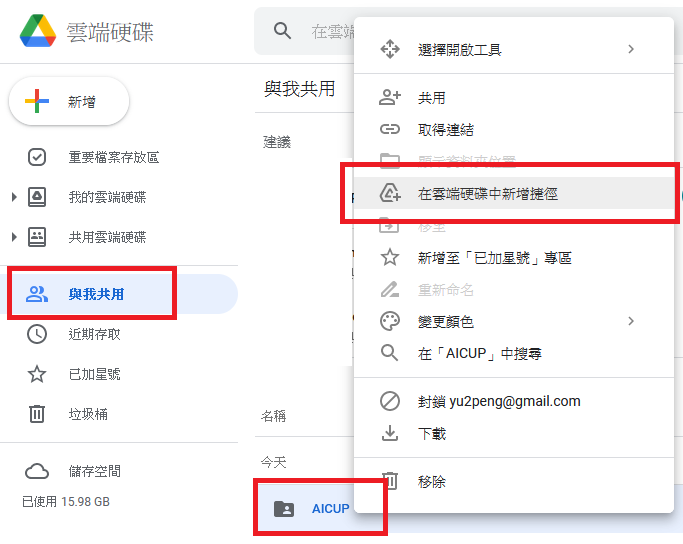

本範例將捷徑新增在: 我的雲端硬碟 > Colab Notebooks

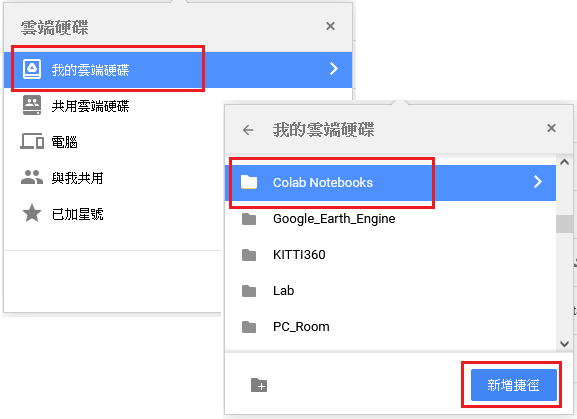

# 掛載Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


測試連接google drive (使用上一步驟的共用資料捷徑)

In [ ]:
!ls /content/drive/My\ Drive/Colab\ Notebooks/AICUP/

 AiCup2022農地作物影像辨識競賽說明.pdf	'crop Image Classification model-VGG16'
 AICUP報名流程.pdf			'Crop Image Classification-VGG16.ipynb'
'crop image classification'


# 訓練網路

匯入Keras與其它需要使用的模組

In [ ]:
from tensorflow.keras.models import Sequential,Model,load_model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras import utils,optimizers
import numpy as np
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plot
import os, math
from random import randint

定義類別

In [ ]:
# 定義 label: 0-corn, 1-garlic, 2-peanut, 3-pineapple, 4-rice, 5-bareland
def get_class_list():
  crop_list = ['corn','garlic','peanut','pineapple','rice','bareland']
  return crop_list

# 取得訓練集影像及label值
def get_images(directory):
    Images = []
    Labels = []
    label = 0
    classes = get_class_list()    
    for folder in os.listdir(directory): # 影像分別儲存在以類別命名的資料夾.
        label = classes.index(folder) # 依資料夾名稱轉換為label值       
        for img_file in os.listdir(os.path.join(directory, folder)):
            image = cv2.imread(os.path.join(directory, folder, img_file)) # OpenCV 讀取影像資料  
            image = cv2.resize(image,(224,224))           
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels) # 隨機排序

# 依label值轉換為類別名稱
def get_class(label_code):
    classes = get_class_list();    
    return classes[label_code]

讀取訓練資料集

In [ ]:
train_dir = '/content/drive/My Drive/Colab Notebooks/AICUP/crop image classification/train/'

In [ ]:
train_images, train_labels = get_images(train_dir) 

train_images = np.array(train_images) 
train_labels = np.array(train_labels)

In [ ]:
print("Shape of Images:",train_images.shape)
print("Shape of Labels:",train_labels.shape)

Shape of Images: (6000, 224, 224, 3)
Shape of Labels: (6000,)


In [ ]:
# 檢視資料影像, 分類及label
def plot_images(Images, Labels, Prediction=[], num=12):    
    if num > 30: num = 30 
    row = math.ceil(num/6)
    fig, ax = plot.subplots(row, 6, figsize=(24, row*3))
    pic = 1
    for i in range(row):
      for j in range(6):
        if pic <= num:
          idx = randint(0,len(Images)-1)          
          ax[i,j].imshow(Images[idx])  
          title = get_class(Labels[idx])
          if len(Prediction) > 0:
            title = "gt={},p={}".format(title, get_class(Prediction[idx]))                      
          ax[i,j].set_title(title)

        ax[i,j].axis('off')
        pic += 1                                            
    plot.show()

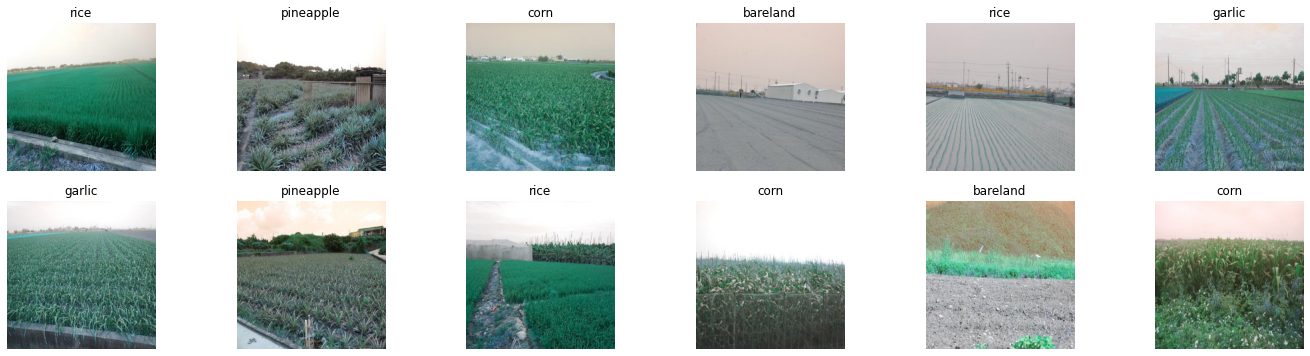

In [ ]:
plot_images(train_images, train_labels)

建構網路

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', input_shape=(224,224,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu')) 
model.add(Dense(4096, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(6, activation='softmax')) 

opt = optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer=opt)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

模型訓練

In [ ]:
train_history = model.fit(x=train_images, y=train_labels, validation_split=0.2, epochs=20, batch_size=32)

Epoch 1/20
150/150 [==============================] - 167s 993ms/step - loss: 1.4593 - accuracy: 0.4002 - val_loss: 1.1044 - val_accuracy: 0.5783
Epoch 2/20
150/150 [==============================] - 146s 975ms/step - loss: 1.0673 - accuracy: 0.5860 - val_loss: 1.1157 - val_accuracy: 0.5933
Epoch 3/20
150/150 [==============================] - 147s 978ms/step - loss: 0.9363 - accuracy: 0.6460 - val_loss: 0.7349 - val_accuracy: 0.7517
Epoch 4/20
150/150 [==============================] - 147s 978ms/step - loss: 0.7897 - accuracy: 0.7194 - val_loss: 0.6979 - val_accuracy: 0.7600
Epoch 5/20
150/150 [==============================] - 147s 978ms/step - loss: 0.6618 - accuracy: 0.7685 - val_loss: 0.7607 - val_accuracy: 0.7242
Epoch 6/20
150/150 [==============================] - 147s 978ms/step - loss: 0.6197 - accuracy: 0.7829 - val_loss: 0.5655 - val_accuracy: 0.8158
Epoch 7/20
150/150 [==============================] - 147s 978ms/step - loss: 0.4799 - accuracy: 0.8381 - val_loss: 0.7897 -

In [ ]:
model_dir = '/content/drive/My Drive/Colab Notebooks/'

儲存模型

In [ ]:
model.save(model_dir)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/assets


準確度

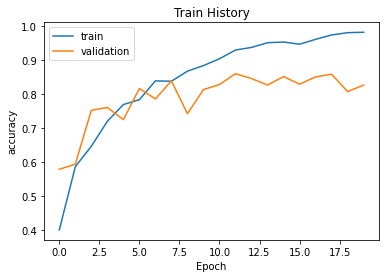

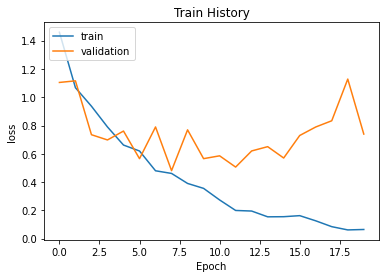

In [ ]:
# 顯示訓練結果
def show_train_history(train_history, train, validation):  
    plot.plot(train_history.history[train])
    plot.plot(train_history.history[validation])
    plot.title('Train History')  
    plot.ylabel(train)  
    plot.xlabel('Epoch')  
    plot.legend(['train', 'validation'], loc='upper left')  
    plot.show()
    
show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

# 測試網路

載入預測模型

In [ ]:
#model = load_model(model_dir)

讀取測試資料集影像資料

In [ ]:
test_dir = '/content/drive/My Drive/Colab Notebooks/AICUP/crop image classification/test/'
test_images,test_labels = get_images(test_dir)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

print("Shape of Images:",test_images.shape)
print("Shape of Labels:",test_labels.shape)

Shape of Images: (120, 224, 224, 3)
Shape of Labels: (120,)


評估測試集準確度

In [ ]:
model.evaluate(test_images, test_labels)

4/4 [==============================] - 4s 1s/step - loss: 0.6581 - accuracy: 0.8417


[0.6581400036811829, 0.8416666388511658]

gt:ground truth, p: prediction



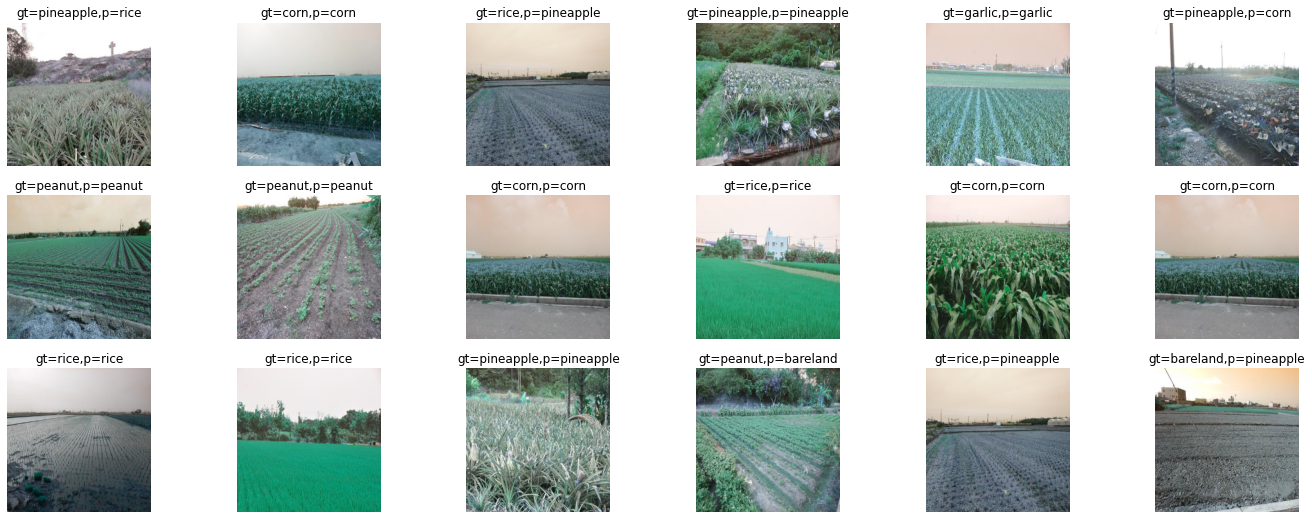

In [ ]:
prediction_prob = model.predict(test_images)
prediction = np.argmax(prediction_prob,axis=1)

print("gt:ground truth, p: prediction\n")
plot_images(test_images, test_labels, prediction, 18)

# 預測

讀取資料

In [ ]:
pred_dir = '/content/drive/My Drive/Colab Notebooks/AICUP/crop image classification/predict/'
pred_images=[]
for img_file in os.listdir(pred_dir):
  image = cv2.imread(os.path.join(pred_dir,img_file))  
  image = cv2.resize(image,(224,224))           
  pred_images.append(image)

print(len(pred_images))

25


顯示預測結果

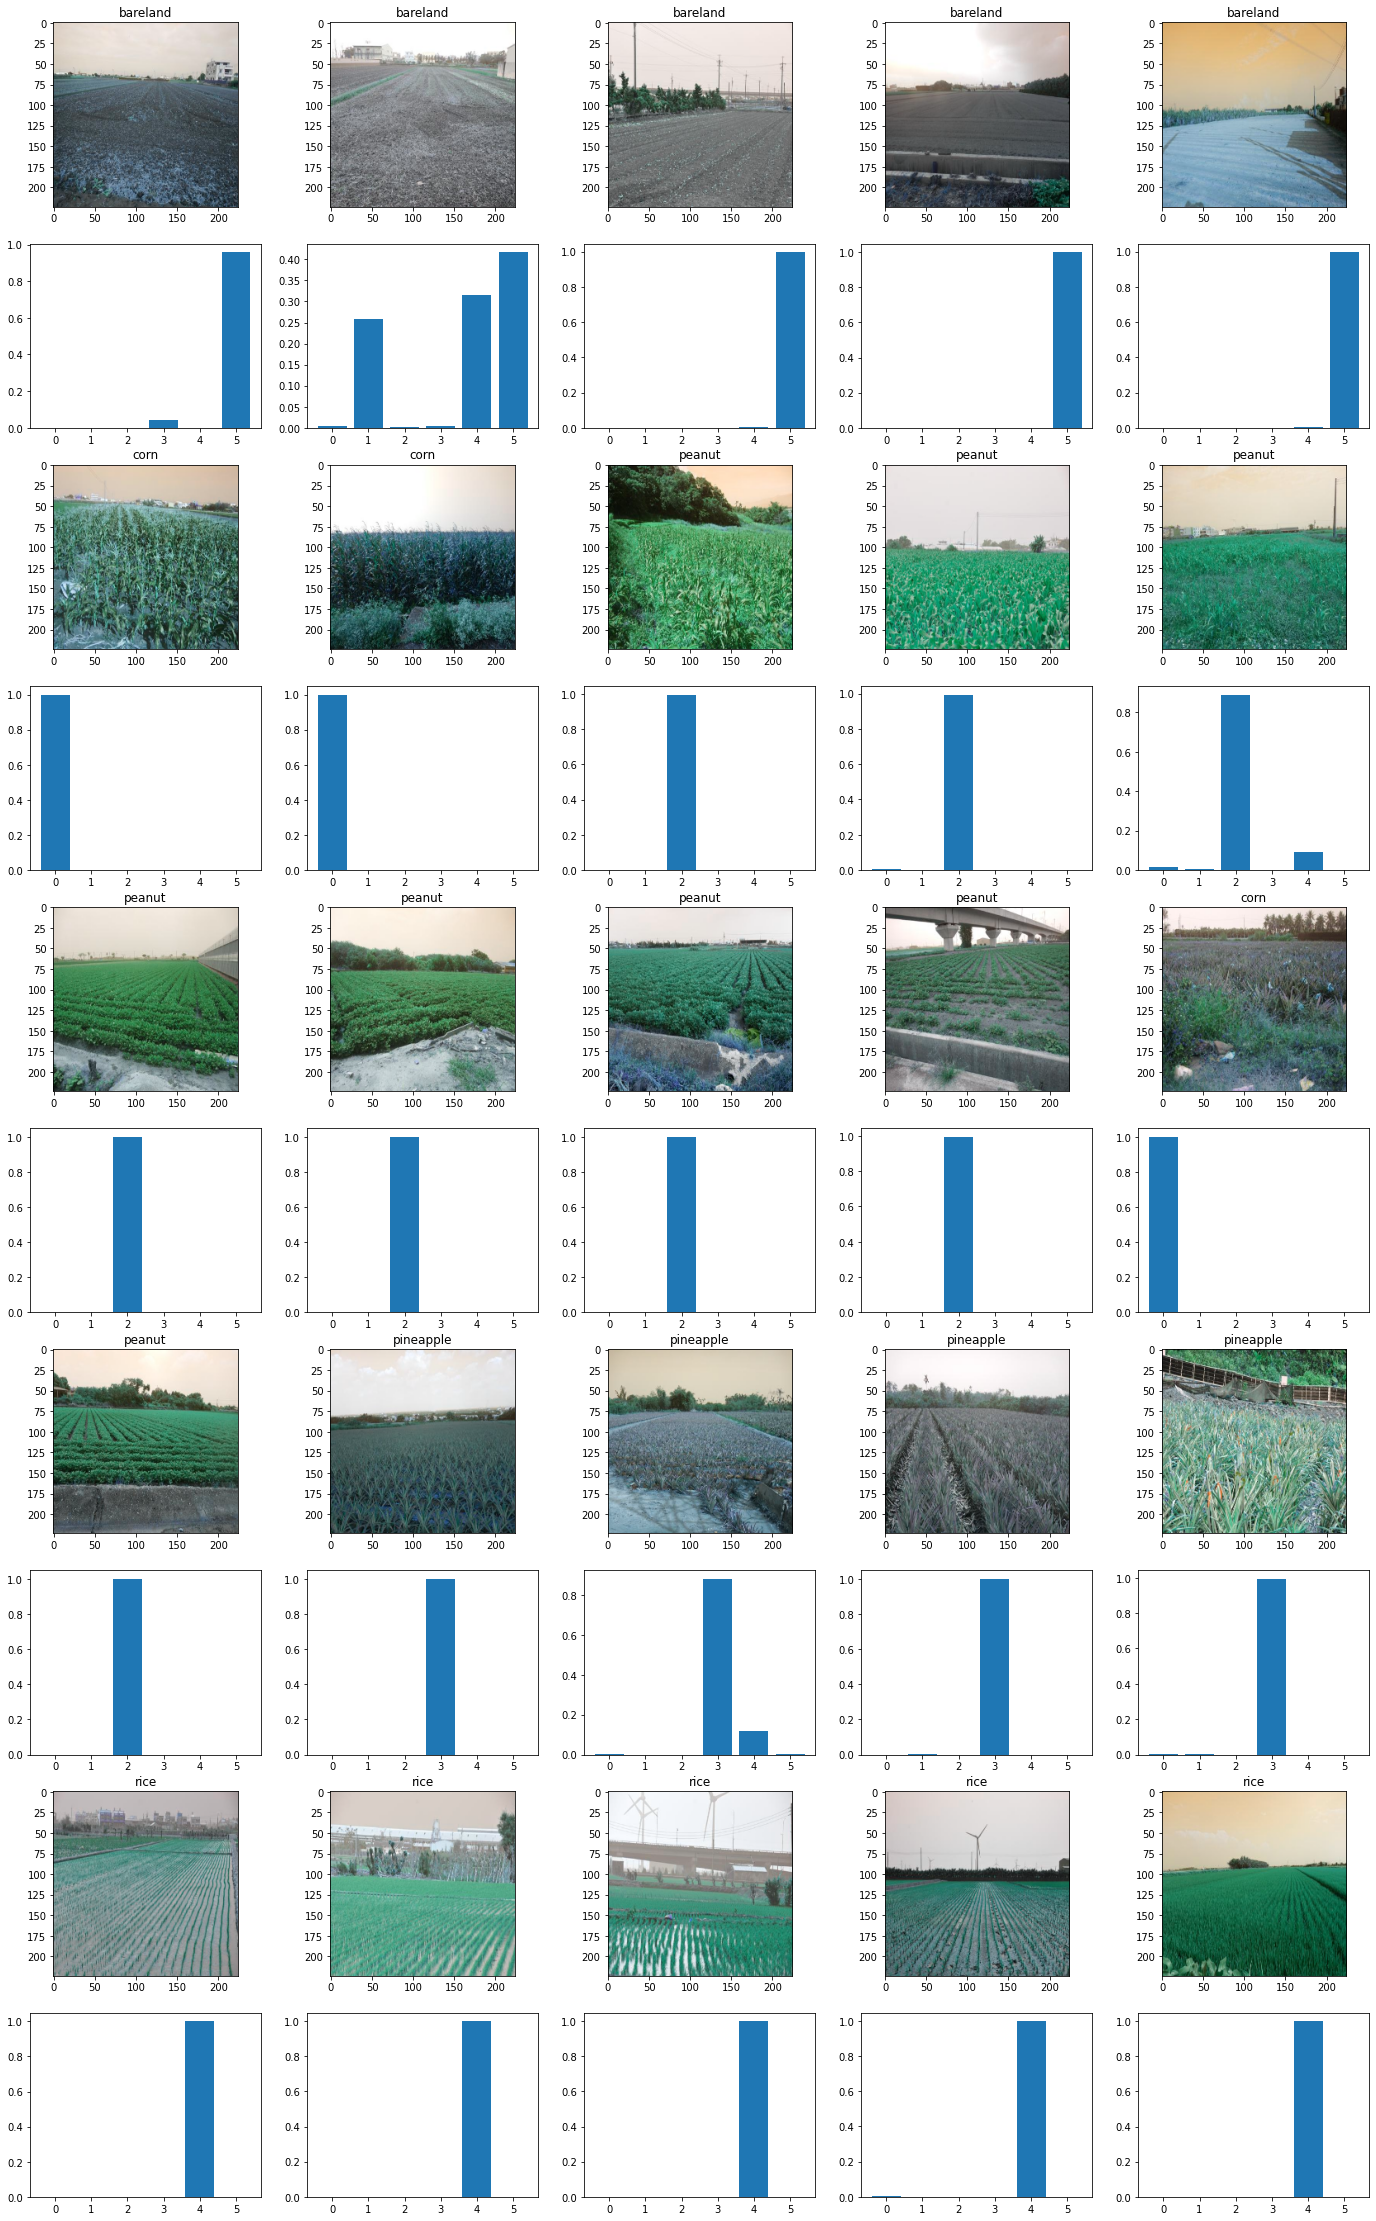

In [ ]:
row = 10
fig, ax = plot.subplots(row, 5, figsize=(24, 40))
i = 0   # 列數
pic1 = 0  # image圖 index
pic2 = 0  # bar 圖 index
while i < row:
  # 第一列顯示影像 
  for j in range(5):
    pred_image = np.array([pred_images[pic1]]) 
    pred_prob = model.predict(pred_image)[0]
    pred_label = np.argmax(pred_prob)      # 回傳最大數值的位置(index).
    pred_class = get_class(pred_label)   
    ax[i,j].imshow(pred_images[pic1])    
    ax[i,j].set_title(pred_class)  
    pic1+=1
  
  # 第二列顯示預測的機率
  i+=1
  for j in range(5):
    pred_image = np.array([pred_images[pic2]]) 
    pred_prob = model.predict(pred_image)[0]  
    prob_value = pred_prob.reshape(6)
    ax[i,j].bar(range(6),prob_value)
    pic2+=1
  i+=1